In [1]:
import sys
sys.path.append('../..')
from model import processing
from model.amm.money_market import MoneyMarket, MoneyMarketAsset, CDP
from model.amm.trade_strategies import liquidate_cdps
mm = processing.get_current_money_market()
original_cdps = mm.cdps
print(mm)

Pool Address: 0x1b02E051683b5cfaC5929C25E84adb26ECf87B38
money_market(    liquidity: {'USDC': 393597418483, 'USDT': 450608956964, 'WBTC': 1037214556, 'DOT': 6307136795328761, 'vDOT': 3311008591658295}
    liquidation threshold: {('USDC', 'USDT'): 0.93, ('USDC', 'WBTC'): 0.9, ('USDC', 'DOT'): 0.9, ('USDC', 'vDOT'): 0.9, ('USDT', 'USDC'): 0.93, ('USDT', 'WBTC'): 0.9, ('USDT', 'DOT'): 0.9, ('USDT', 'vDOT'): 0.9, ('WBTC', 'USDC'): 0.7, ('WBTC', 'USDT'): 0.7, ('WBTC', 'DOT'): 0.7, ('WBTC', 'vDOT'): 0.7, ('DOT', 'USDC'): 0.8, ('DOT', 'USDT'): 0.8, ('DOT', 'WBTC'): 0.8, ('DOT', 'vDOT'): 0.9, ('vDOT', 'USDC'): 0.7, ('vDOT', 'USDT'): 0.7, ('vDOT', 'WBTC'): 0.7, ('vDOT', 'DOT'): 0.9}
    liquidation bonus: {('USDC', 'USDT'): 0.014999999999999902, ('USDC', 'WBTC'): 0.030000000000000027, ('USDC', 'DOT'): 0.030000000000000027, ('USDC', 'vDOT'): 0.030000000000000027, ('USDT', 'USDC'): 0.014999999999999902, ('USDT', 'WBTC'): 0.030000000000000027, ('USDT', 'DOT'): 0.030000000000000027, ('USDT', 'vDOT'

In [2]:
omnipool_router = processing.get_omnipool_router()
# print(omnipool_router)
print('Got Omnipool data...')

Got Omnipool data...


In [3]:
from model.amm.omnipool_amm import OmnipoolState
from model.amm.stableswap_amm import StableSwapPoolState

omnipool = omnipool_router.exchanges['omnipool']
lrna_price_1 = mm.get_oracle_price('DOT') / omnipool.lrna_price('DOT')
lrna_price_2 = mm.get_oracle_price('vDOT') / omnipool.lrna_price('vDOT')
# print(lrna_price_1, lrna_price_2)
lrna_price = (lrna_price_1 + lrna_price_2) / 2

for exchange in [exchange for exchange in omnipool_router.exchanges.values() if isinstance(exchange, StableSwapPoolState)]:
    priced_assets = [tkn[:-2] for tkn in exchange.asset_list if tkn[:-2] in mm.prices]
    pool_price = sum(mm.get_oracle_price(tkn) for tkn in priced_assets) / len(priced_assets)
    print(f"Average price of assets in {exchange.unique_id} is {pool_price}.")
    # print(exchange, '\n')
    for tkn in exchange.asset_list:
        tkn_name = tkn[:-2]
        tkn_price = pool_price
        new_liquidity = exchange.liquidity[tkn]
        new_lrna = new_liquidity * tkn_price / lrna_price
        new_shares = new_liquidity
        if tkn_name not in omnipool.asset_list:
            omnipool.add_token(
                tkn=tkn_name,
                liquidity=new_liquidity,
                lrna=new_lrna,
                shares=new_shares,
                protocol_shares=new_shares
            )
        else:
            omnipool.liquidity[tkn_name] += new_liquidity
            omnipool.lrna[tkn_name] += new_lrna
            omnipool.shares[tkn_name] += new_shares
            omnipool.protocol_shares[tkn_name] += new_shares

# print(omnipool)
# print(omnipool.sub_pools)

Average price of assets in 4-Pool is 1.0001305133333334.
Average price of assets in 2-Pool101 is 88432.19687995.
Average price of assets in 2-Pool102 is 1.000179205.


In [ ]:
# replace DOT collateral with HDX
hdx = MoneyMarketAsset(
    name='HDX',
    price=omnipool.usd_price('HDX', 'USDT'),
    liquidity=10000000,
    liquidation_bonus=0.10,
    liquidation_threshold=0.7,
    ltv=0.6
)
mm.add_new_asset(hdx)
mm.prices = {tkn: omnipool.usd_price(tkn, 'USDT') for tkn in mm.prices}
# distribution = processing.distribute_value(
#     num_positions=50,
#     total_value=1000000,
#     concentration=0.8
# )
price_ratio = mm.get_oracle_price('DOT') / mm.get_oracle_price('HDX')
hdx_cdps = []
for cdp in [cdp for cdp in original_cdps if cdp.health_factor > 0]:
    if 'DOT' in cdp.collateral:
        hdx_collateral = cdp.collateral['DOT'] * price_ratio * 8 / 7
        other_collateral = {tkn: cdp.collateral[tkn] for tkn in cdp.collateral if tkn != 'DOT'}
        debt_value = sum([cdp.debt[tkn] * mm.prices[tkn] for tkn in cdp.debt])
        new_cdp = CDP(
            collateral={'HDX': hdx_collateral, **other_collateral},
            debt={'USDT': debt_value / mm.prices['USDT']}
        )
        precision = 20
        new_cdp.health_factor = mm.get_health_factor(new_cdp)
        if abs(cdp.health_factor - new_cdp.health_factor) / cdp.health_factor > 2 ** -precision:
            for i in range(precision):
                # print(f"target: {cdp.health_factor}, value: {new_cdp.health_factor}")
                if mm.get_health_factor(new_cdp) < cdp.health_factor:
                    new_cdp.collateral['HDX'] += hdx_collateral * 2 ** -i
                else:
                    new_cdp.collateral['HDX'] -= hdx_collateral * 2 ** -i
                new_cdp.health_factor = mm.get_health_factor(new_cdp)
        
        if not(mm.is_toxic(new_cdp)):
            hdx_cdps.append(new_cdp)
hdx_cdps = hdx_cdps[:50]

# scale
hdx_total = sum([position.collateral['HDX'] for position in hdx_cdps])
scale_ratio = hdx.liquidity / hdx_total
print('multiplying DOT positions by', scale_ratio)
for cdp in hdx_cdps:
    health_factor = cdp.health_factor
    cdp.debt['USDT'] *= scale_ratio
    for tkn in cdp.collateral:
        cdp.collateral[tkn] *= scale_ratio
    if abs(mm.get_health_factor(cdp) - health_factor) > 0.0000001:
        print('inaccurate health factor')

mm.cdps = list(filter(lambda cdp: not mm.is_toxic(cdp), hdx_cdps))
positions_removed = len(hdx_cdps) - len(mm.cdps)
if positions_removed > 1:
    print(f"removed {positions_removed} toxic positions")
elif positions_removed == 1:
    print(f"removed one toxic position")

In [89]:
from model.amm.trade_strategies import liquidate_cdps, omnipool_arbitrage, general_arbitrage, constant_swaps
from model.amm.global_state import GlobalState, money_market_update
from model.amm.infinite_liquidity import CEXDummy
from model.amm.agents import Agent
from matplotlib import pyplot as plt
import model.run as run
import math

# time_steps = 100
initial_price = {'HDX': hdx.price}
final_price = {'HDX': hdx.price / 4}
# prices = [{
#     tkn: initial_price[tkn] + (final_price[tkn] - initial_price[tkn]) * (i / time_steps)
#     for tkn in initial_price
# } for i in range(time_steps + 1)]
binance = CEXDummy(mm.prices, unique_id='binance')

def update_prices(state):
    prices = {tkn: state.pools['omnipool'].usd_price(tkn, 'USDT') for tkn in state.money_market.prices}
    state.external_market.update(prices)
    state.pools['binance'].prices.update(prices)
    state.money_market.prices.update(prices)

def trade_to_price(onmnipool, tkn_sell, target_price):
    # this is the target price in USD - convert to LRNA
    target_price_lrna = target_price / omnipool.usd_price(tkn_sell, 'USDT') * omnipool.lrna_price(tkn_sell)
    # print(omnipool.lrna_price(tkn_sell) / target_price_lrna)
    # print(target_price_lrna)
    k = omnipool.lrna[tkn_sell] * omnipool.liquidity[tkn_sell]
    target_x = math.sqrt(k / target_price_lrna)
    dx = target_x - omnipool.liquidity[tkn_sell]
    return dx

def calculate_toxic_debt(state: GlobalState):
    toxic_debt = 0
    omnipool = state.pools['omnipool']
    for cdp in state.money_market.cdps:
        debt = omnipool.value_assets(cdp.debt, numeraire='USDT')
        collateral = omnipool.value_assets(cdp.collateral, numeraire='USDT')
        if debt > collateral:
            toxic_debt += debt
    return toxic_debt

toxic_debt = []
hdx_sell_total = trade_to_price(omnipool, 'HDX', final_price['HDX'])
runs = []
run_lengths = [i for i in range(1, 20, 1)]
for time_steps in run_lengths:
    initial_state = GlobalState(
        money_market=mm,
        pools={
            'omnipool': omnipool,
            'binance': binance
        },
        agents={
            'liquidator': Agent(
                enforce_holdings=False,
                trade_strategy=liquidate_cdps('omnipool')
            ),
            'panic seller': Agent(
                trade_strategy=constant_swaps(
                    'omnipool',
                    sell_asset='HDX',
                    buy_asset='LRNA',
                    sell_quantity=hdx_sell_total / time_steps
                )
            )
            # 'arbitrageur': Agent(
            #     enforce_holdings=False,
            #     trade_strategy=general_arbitrage(
            #         exchanges=[omnipool, binance]
            #     )
            # )
        },
        evolve_function = update_prices,
        external_market = mm.prices.copy()
    )
    events = run.run(initial_state, time_steps)
    runs.append(events)
    toxic_debt.append(calculate_toxic_debt(events[-1]))

Starting simulation...
Execution time: 0.027 seconds.
Starting simulation...
Execution time: 0.013 seconds.
Starting simulation...
Execution time: 0.022 seconds.
Starting simulation...
Execution time: 0.041 seconds.
Starting simulation...
Execution time: 0.044 seconds.
Starting simulation...
Execution time: 0.041 seconds.
Starting simulation...
Execution time: 0.031 seconds.
Starting simulation...
Execution time: 0.05 seconds.
Starting simulation...
Execution time: 0.087 seconds.
Starting simulation...
Execution time: 0.084 seconds.
Starting simulation...
Execution time: 0.071 seconds.
Starting simulation...
Execution time: 0.062 seconds.
Starting simulation...
Execution time: 0.097 seconds.
Starting simulation...
Execution time: 0.053 seconds.
Starting simulation...
Execution time: 0.048 seconds.
Starting simulation...
Execution time: 0.101 seconds.
Starting simulation...
Execution time: 0.07 seconds.
Starting simulation...
Execution time: 0.101 seconds.
Starting simulation...
Executi

In [86]:
print("omnipool prices:")
print('start:', '\n    '.join(f"{tkn}: {price}" for tkn, price in runs[-1][0].money_market.prices.items()))
print('end:\n   ', '\n    '.join(f"{tkn}: {price}" for tkn, price in runs[-1][-1].money_market.prices.items()))

omnipool prices:
start: USDC: 1.0000014697580517
    USDT: 1.0
    WBTC: 88416.65114256612
    DOT: 4.6870831628418035
    vDOT: 6.8861860733892115
    HDX: 0.011716789323719104
end:
    USDC: 0.9854984928163086
    USDT: 1.0
    WBTC: 87134.34837445416
    DOT: 4.619106603716172
    vDOT: 6.785910808194029
    HDX: 0.0035917471734026826


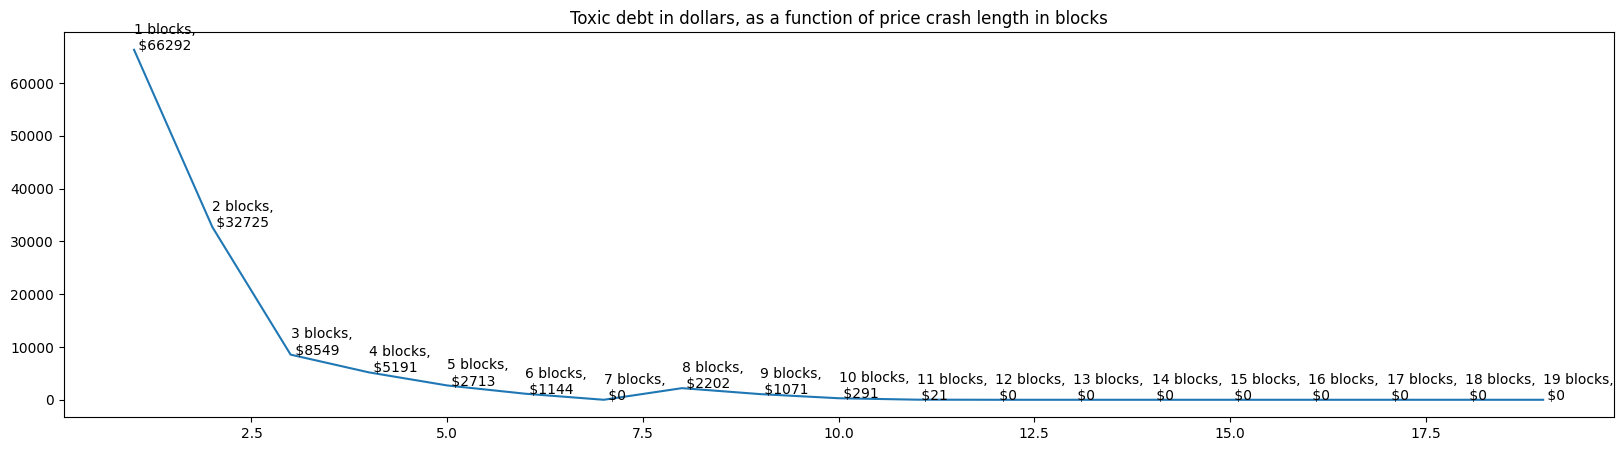

In [87]:
plt.figure(figsize=(20, 5))
plt.plot(run_lengths, toxic_debt)
for i in range(len(run_lengths)):
    plt.annotate(f"{run_lengths[i]} blocks,\n ${round(toxic_debt[i])}", (run_lengths[i], toxic_debt[i]))
plt.title("Toxic debt in dollars, as a function of price crash length in blocks")
plt.show()

In [88]:
hdx_sell_total * omnipool.usd_price('HDX', 'USDT')

718671.1829328527

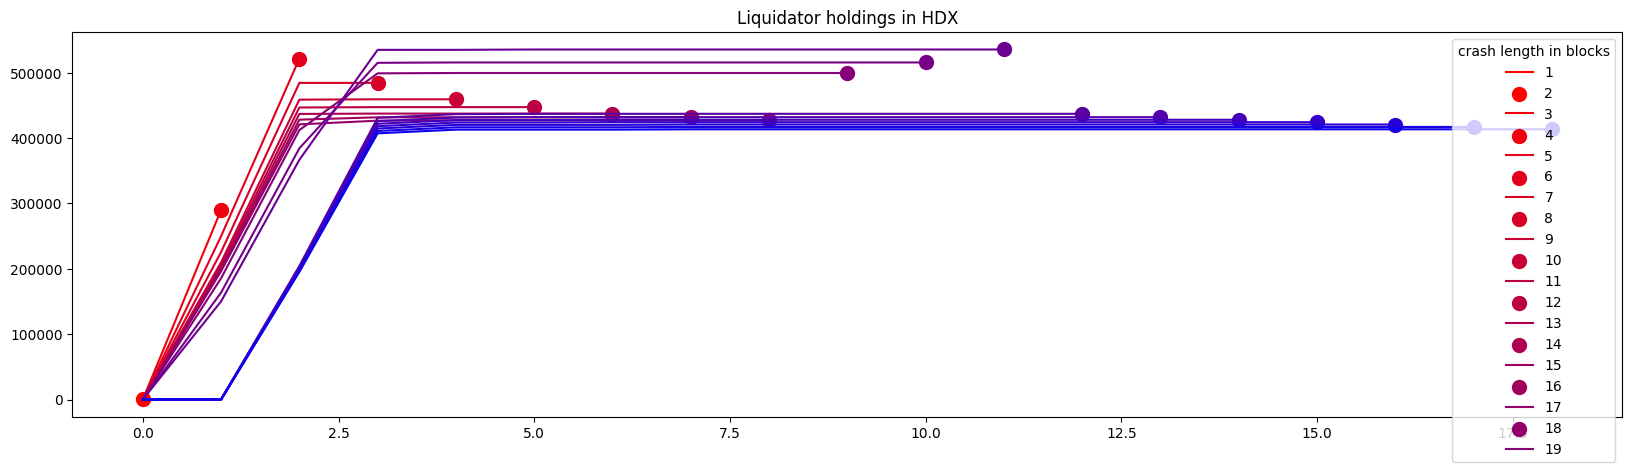

In [84]:
from model import plot_utils as pu
plt.figure(figsize=(20, 5))
colors = pu.color_gradient(len(run_lengths), (255, 0, 0), (0, 0, 255))
for i in range(len(run_lengths)):
    events = runs[i]
    color = colors[i]
    plt.plot([event.agents['liquidator'].holdings['HDX'] for event in events], color)
    plt.scatter(len(events) - 1, events[-1].agents['liquidator'].holdings['HDX'], color=color, s=100)
plt.legend(run_lengths, title='crash length in blocks')
plt.title('Liquidator holdings in HDX')
plt.show()

In [59]:
1 - runs[9][-1].pools['omnipool'].usd_price('HDX', 'USDT') / (omnipool.usd_price('HDX', 'USDT') / 4)

0.11034478028077388

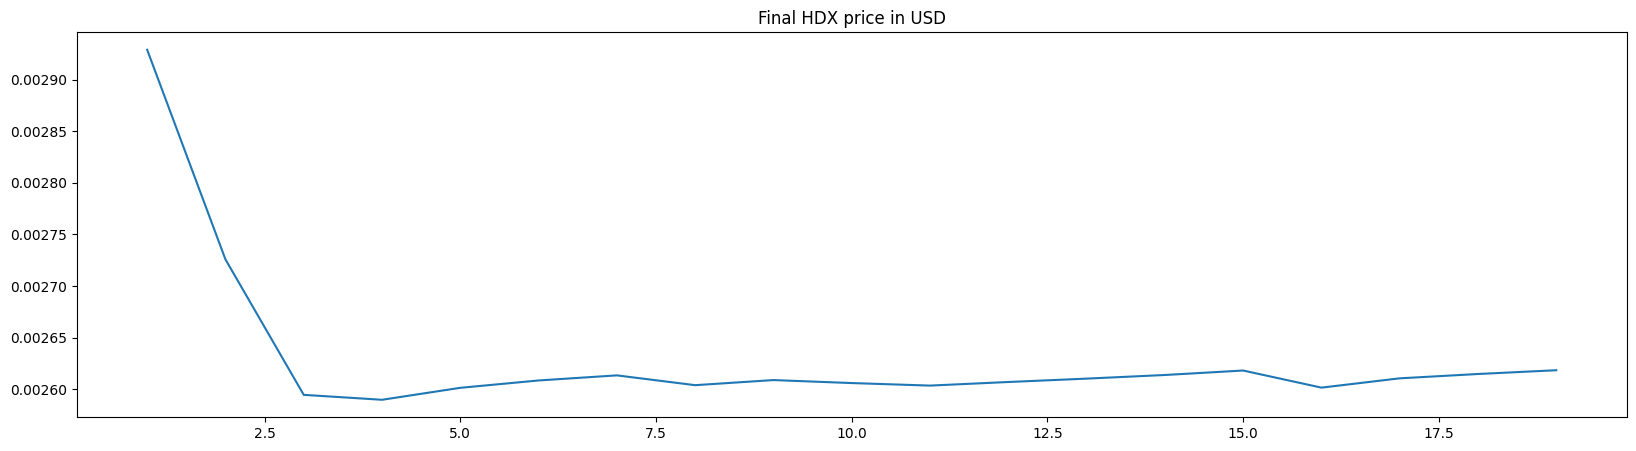

In [72]:
plt.figure(figsize=(20, 5))
plt.plot(run_lengths, [events[-1].pools['omnipool'].usd_price('HDX', 'USDT') for events in runs])
plt.title('Final HDX price in USD')
plt.show()

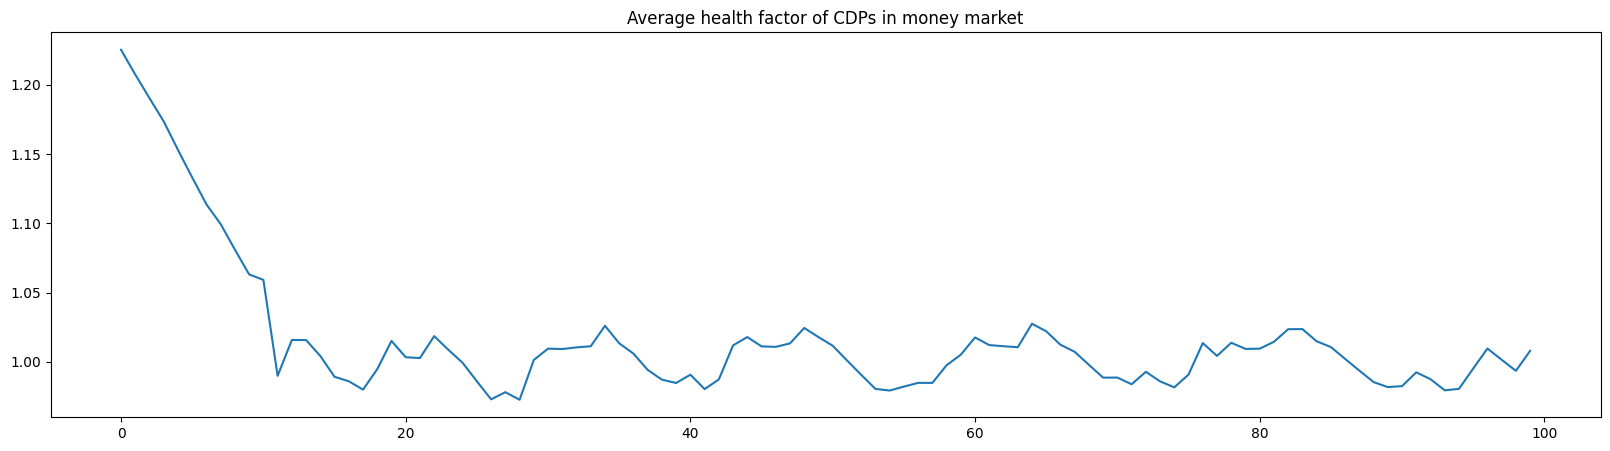

In [41]:
plt.figure(figsize=(20, 5))
plt.plot([sum([event.money_market.get_health_factor(cdp) for cdp in event.money_market.cdps]) / len(event.money_market.cdps) for event in events])
plt.title('Average health factor of CDPs in money market')
plt.show()

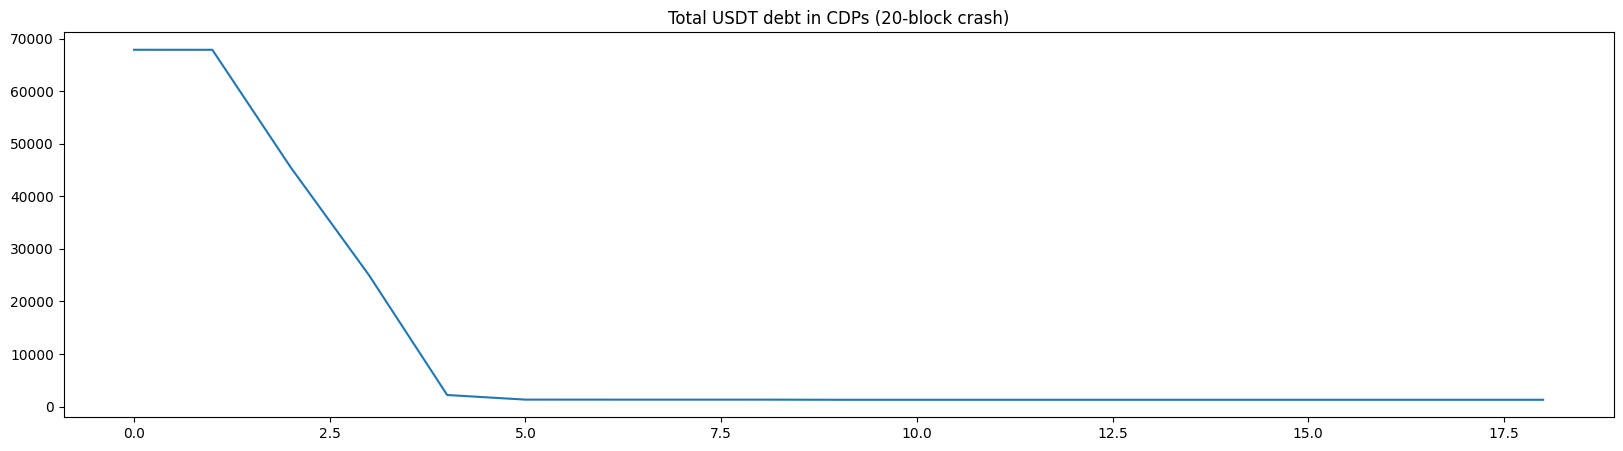

In [69]:
plt.figure(figsize=(20, 5))
liquidated_cdps = [sum([sum(cdp.debt.values()) for cdp in event.money_market.cdps]) for event in runs[-1]]
plt.plot(liquidated_cdps)
plt.title('Total USDT debt in CDPs (20-block crash)')
plt.show()

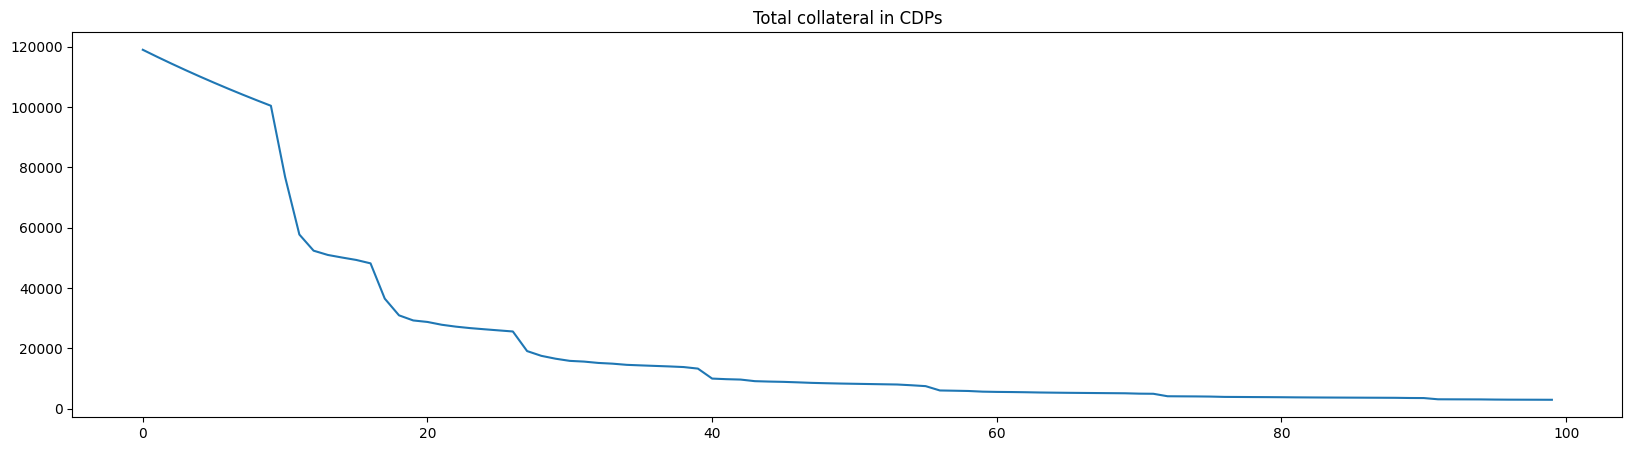

In [13]:
plt.figure(figsize=(20, 5))
liquidated_cdps = [sum([sum([cdp.collateral[c] * event.external_market[c] for c in cdp.collateral]) for cdp in event.money_market.cdps]) for event in events]
plt.plot(liquidated_cdps)
plt.title('Total collateral in CDPs')
plt.show()

In [14]:
print([events[-1].pools['omnipool'].lrna_price('HDX') for events in runs])
print([events[0].pools['omnipool'].lrna_price('HDX') for events in runs])
print(hdx_sell_total)
print(omnipool.liquidity['HDX'])
print(runs[0][-1].pools['omnipool'].lrna_price('HDX') / runs[0][0].pools['omnipool'].lrna_price('HDX'))

[0.00010977448658905787, 0.00011042364902170892, 0.00011007321463732111, 0.00011006147850623369, 0.00010996119497535323, 0.00010982362282059952, 0.00010980127216655717, 0.00010975298375511838, 0.00010976640387477102, 0.00010977045796926555]
[0.00040202115166358877, 0.0004412204407291574, 0.0004555681206199594, 0.00046300583461437626, 0.00046755622705445954, 0.00047062719152362546, 0.0004728392991982082, 0.00047450863120933925, 0.00047581311991040713, 0.0004768605878932298]
83787722.53476647
83787722.53476647
0.2730564949998381


In [15]:
toxic_debt = []

for i, event in enumerate(runs[-1]):
    toxic_debt.append([])
    for j, cdp in enumerate(event.money_market.cdps):
        if event.pools['omnipool'].value_assets(cdp.debt, numeraire='USDT') > event.pools['omnipool'].value_assets(cdp.collateral, numeraire='USDT'):
            # bad debt
            toxic_debt[i].append({
                'debt': {
                    'assets': cdp.debt,
                    'value': event.pools['omnipool'].value_assets(cdp.debt, numeraire='USDT')
                },
                'collateral': {
                    'assets': cdp.collateral,
                    'value': event.pools['omnipool'].value_assets(cdp.collateral, numeraire='USDT')
                },
                'index': j
            })

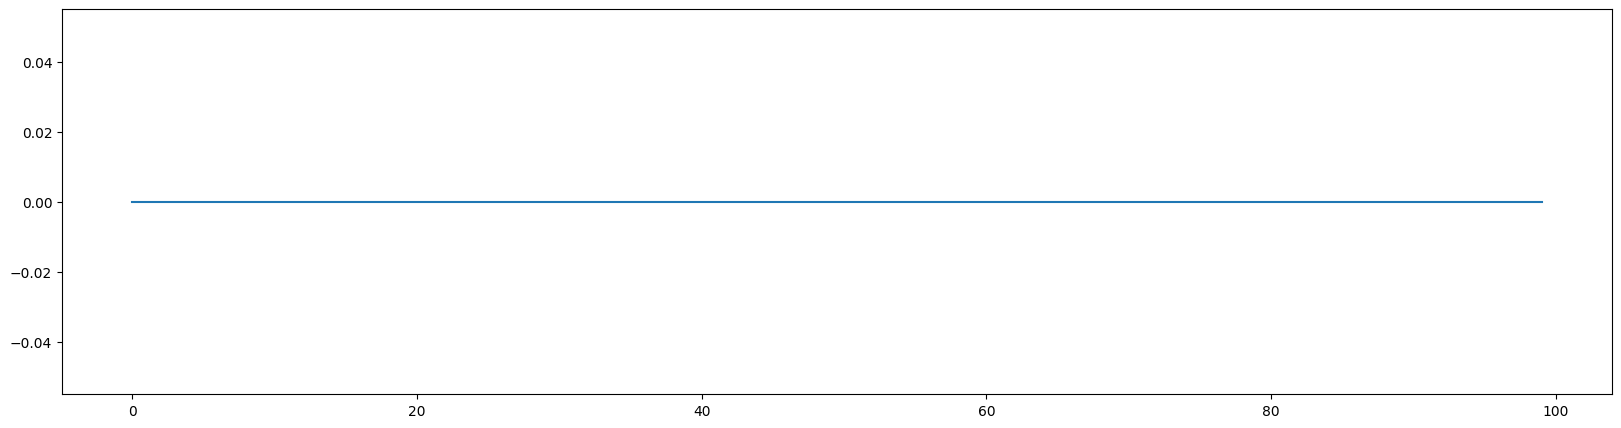

In [16]:
plt.figure(figsize=(20, 5))
plt.plot([len(step) for step in toxic_debt])

In [17]:
for cdp in toxic_debt[-1]:
    print(f"  index: {cdp['index']}")
    print(f"    debt: {cdp['debt']}")
    print(f"    collateral: {cdp['collateral']}")

In [18]:
for i in [cdp['index'] for cdp in toxic_debt[-1]]:
    print(hdx_cdps[i])
    print('    value:')
    for tkn in hdx_cdps[i].collateral:
        print(f"{tkn}: {mm.value_assets({tkn: hdx_cdps[i].collateral[tkn]})}")

In [19]:
toxic_debt[-1]


[]

In [20]:
plt.figure(figsize=(20, 5))
plt.plot([event.agents['arbitrageur'].holdings['HDX'] for event in events])

KeyError: 'arbitrageur'

<Figure size 2000x500 with 0 Axes>

In [ ]:
import model.plot_utils as pu
pu.plot(events, agent='arbitrageur', prop='holdings')

In [ ]:
events[-1]

In [ ]:
events[-1]

In [ ]:
events[-1].pools['binance'].prices

In [ ]:
sorted([(tkn, events[-1].pools['omnipool'].usd_price(tkn, 'USDT')) for tkn in omnipool.asset_list])

In [ ]:
final_state = events[-1]
final_state.evolve()
omnipool = final_state.pools['omnipool']
print("{")
for tkn in omnipool.asset_list:
    print(f"    '{tkn}': {{'liquidity': {omnipool.liquidity[tkn]}, 'LRNA': {omnipool.lrna[tkn]}}},")
print("}")
# print(f"    'DOT': {{'liquidity': {omnipool.liquidity['DOT']}, 'LRNA': {omnipool.lrna['DOT']}}}\n}}")

In [ ]:
binance = final_state.pools['binance']
print("{")
for tkn in binance.asset_list:
    print(f"    ''{tkn}'': {binance.prices[tkn]},")
print("}")

In [ ]:
binance = final_state.pools['binance']
print("{")
for tkn in binance.asset_list:
    print(f"    ''{tkn}'': {binance.prices[tkn]},")
print("}")

In [ ]:
len(events)

In [ ]:
sum([mm.value_assets(cdp.debt) for cdp in hdx_cdps])

In [ ]:
initial_price['HDX']

In [ ]:
test_cdp = CDP(
    collateral={'HDX': 400 / initial_price['HDX'], 'USDT': 600},
    debt={'USDT': 750}
)

In [ ]:
mm.cdp_liquidation_threshold(test_cdp)

In [ ]:
mm.get_health_factor(test_cdp)

In [ ]:
mm.prices['HDX'] /= 2

In [ ]:
mm.calculate_liquidation(test_cdp, 'USDT')